ADAM Cody & DE ZORDO Benjamin

<font  style="font-size: 4rem; color: darkviolet"> Logistic Regression as a Neural Network </font>

AA - 2022/23 - TP5

In this assignment, you will build a logistic regression classifier to recognize cats using a Neural Network approach. The goal is to build a general architecture of a learning algorithm, including initializing parameters, calculating the cost function and its gradient, and using an optimization algorithm (gradient descent). This will help you develop a better understanding and intuition about deep learning.

### Table of Contents
- [1 - Dataset](#1)
    - [Exercise 1.1 - dimensions and shapes](#ex-1.1)
    - [Exercise 1.2 - reshape the datasets](#ex-1.2)
    - [Exercise 1.3 - standardize the data](#ex-1.3)
- [2 - Building the components of the algorithm](#2)
    - [Exercise 2.1 - initialization](#ex-2.1)
    - [Exercise 2.2 - forward and backward propagation](#ex-2.2)
    - [Exercise 2.3 - optimization](#ex-2.3)
    - [Exercise 2.4 - prediction](#ex-2.4)
- [3 - Merge all functions into a model](#3)
    - [Exercise 3.1 - model](#ex-3.1)

In [185]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
import time
from PIL import Image
from scipy import ndimage

%matplotlib inline

<a name='1'></a>
## <font color='darkviolet'> 1 - Dataset </font>

The problem involves working with a dataset that contains two sets of images: a training set and a test set. The images are classified as either cats (labeled as y=1) or non-cats (labeled as y=0). 

Each image is represented as a matrix of size (num_px,num_px,3), where 3 represents the RGB channels. 
    
The goal is to develop an image recognition algorithm that can accurately classify new images as cats or non-cats. To begin, the dataset is loaded into memory using the provided code.

In [186]:
def load_dataset():
    train_dataset = h5py.File('./data/train_catvnoncat.h5', "r")
    train_set_x = np.array(train_dataset["train_set_x"][:]) # the train set features
    train_set_y = np.array(train_dataset["train_set_y"][:]) # the train set labels

    test_dataset = h5py.File('./data/test_catvnoncat.h5', "r")
    test_set_x = np.array(test_dataset["test_set_x"][:]) # the test set features
    test_set_y = np.array(test_dataset["test_set_y"][:]) # the test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
    return train_set_x, train_set_y, test_set_x, test_set_y, classes

In [187]:
# Loading the data
train_set_x_raw, train_set_y, test_set_x_raw, test_set_y, classes = load_dataset()

y = 0, it's a 'non-cat' picture.


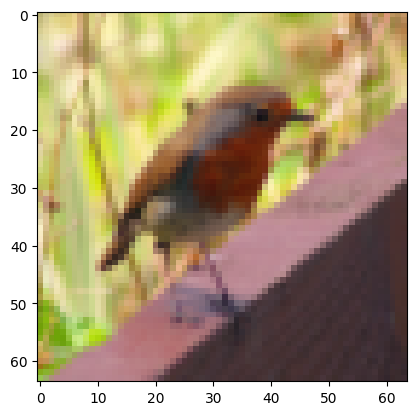

In [188]:
# Example of a picture
index = 10 # 7 -> cat, 10 -> non-cat
plt.imshow(train_set_x_raw[index])
print ("y = " + str(train_set_y[0, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

<a name='ex-1.1'></a>

### <font color='blue'> Exercise 1.1: dimensions and shapes </font>

Determine the values of the variables of interest: m_train, which is to the number of training examples; m_test, which is the number of test examples; num_px, which denotes the height and width of a given training image.

Note that `train_set_x_raw` is a numpy-array with dimensions (m_train, num_px, num_px, 3). To extract the value for m_train, one may access the first element of the shape attribute of `train_set_x_raw` as such `train_set_x_raw.shape[0]`. Similarly, num_px corresponds to the height and width of a training image, and is thus equivalent to the second and third elements of the shape attribute of `train_set_x_raw`.

In [189]:
# write the lines to determine m_train, m_test, num_px
m_train = train_set_x_raw.shape[0] # number of training examples
m_test = test_set_x_raw.shape[0]   # number of test examples
num_px = train_set_x_raw.shape[1]  # height/width of each image : "64x64"
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height / Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_raw.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_raw.shape))
print ("test_set_y shape: " + str(test_set_y.shape))


Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height / Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


<a name='ex-1.2'></a>

### <font color='blue'> Exercise 1.2: reshape the datasets </font>
    
To simplify subsequent computations, reshape the (num_px, num_px, 3) images into a numpy array of shape (num_px * num_px * 3, 1), resulting in a training and test dataset where each column corresponds to a flattened image. The dataset will contain m_train (and m_test) columns, where m_train (and m_test) represent the number of examples.

In [190]:
# write the lines to reshape the training and test examples. Use the  use the reshape() function.
""" 
Transformer la matrice en 2 dimensions en vecteur a une dimension
"""
train_set_x_flatten = train_set_x_raw.reshape(m_train, -1).T
test_set_x_flatten = test_set_x_raw.reshape(m_test, -1).T

print("num_px * num_px * 3 = " + str(num_px*num_px*3))
print("64 * 64 * 3 = " + str(num_px*num_px*3))
print ("train_set_x shape: " + str(train_set_x_flatten.shape))
print ("test_set_x shape: " + str(test_set_x_flatten.shape))

num_px * num_px * 3 = 12288
64 * 64 * 3 = 12288
train_set_x shape: (12288, 209)
test_set_x shape: (12288, 50)


<a name='ex-1.3'></a>

### <font color='blue'> Exercise 1.3: standardize the data </font>
Color images are represented by specifying the red, green, and blue channels (RGB) for each pixel. Consequently, the value of each pixel is expressed as a vector comprising three numbers, ranging from 0 to 255. Dividing each pixel value by 255 scales the pixel values to the range [0, 1], which can make it easier for the model to learn the underlying patterns in the data.
    
<font color='green'> Standardize the dataset by dividing each row by 255.

In [191]:
print("before normalization :", train_set_x_flatten)

before normalization : [[ 17 196  82 ... 143  22   8]
 [ 31 192  71 ... 155  24  28]
 [ 56 190  68 ... 165  23  53]
 ...
 [  0  82 138 ...  85   4   0]
 [  0  80 141 ... 107   5   0]
 [  0  81 142 ... 149   0   0]]


In [192]:
# write the lines to standardize the dataset by dividing each row by 255.
# Trainset :
train_set_x_flatten = train_set_x_flatten/255.
test_set_x_flatten = test_set_x_flatten/255.

In [193]:
print("after normalization :", train_set_x_flatten)

after normalization : [[0.06666667 0.76862745 0.32156863 ... 0.56078431 0.08627451 0.03137255]
 [0.12156863 0.75294118 0.27843137 ... 0.60784314 0.09411765 0.10980392]
 [0.21960784 0.74509804 0.26666667 ... 0.64705882 0.09019608 0.20784314]
 ...
 [0.         0.32156863 0.54117647 ... 0.33333333 0.01568627 0.        ]
 [0.         0.31372549 0.55294118 ... 0.41960784 0.01960784 0.        ]
 [0.         0.31764706 0.55686275 ... 0.58431373 0.         0.        ]]


<a name='2'></a>
## <font color='darkviolet'> 2 - Building the components of the algorithm ##

In this section, we will build a simple algorithm that can distinguish cat images from non-cat images. Specifically, we will build a logistic regression model using a Neural Network approach. 

**Reminder**. The mathematical expression of the logistic regression algorithm, given an input example $x^{(i)}$:

\begin{equation} z^{(i)} = w^T x^{(i)} + b \tag{1} \end{equation}

\begin{equation} \hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2} \end{equation}

\begin{equation} \mathcal{L}(a^{(i)}, y^{(i)}) = - y^{(i)} \log(a^{(i)}) - (1-y^{(i)} ) \log(1-a^{(i)})\tag{3} \end{equation}

\begin{equation} J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4} \end{equation}

**Key steps** we will implement:

1. Initialize the parameters of the model
3. Loop:
   * Calculate loss (forward propagation)
   * Calculate gradient (backward propagation)
   * Update parameters (gradient descent)
        
We will build each step separately and then integrate them into one function called `model()`.

<a name='ex-2.1'></a>
### <font color='blue'> Exercise 2.1: Initializing parameters </font>
    
Implement the function `initialize_with_zeros()` that initializes w as a vector of zeros, and b to zero.
If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [194]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    
    # Implement this function
    w = np.zeros((dim, 1))
    b = 0. # Float because of the assert lower
        
    return w, b

In [195]:
dim = 2
w, b = initialize_with_zeros(dim)

assert type(b) == float
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0.0


<a name='ex-2.2'></a>
### <font color='blue'> Exercise 2.2: Forward and Backward propagation </font>

Now that we have initialized the parameters, we can do the forward and backward propagation steps for learning the parameters.

<font color='green'> a. Implement the sigmoid function using np.exp(). </font>
    
<font color='green'> b. Implement a function `propagate()` that computes the cost function and its gradient. Write your code step by step. Don't use loops for the sum; use np.log(), np.dot(). </font>

**Recap**:

* Forward Propagation:
1. Compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m)})$
3. Calculate the cost function $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

* Backward Propagation key formulas: 

$$ \frac{d J}{d w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{d J}{d b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

Remember : 

$$ Z = w^T X + b $$

$$ Sigmoïde(z) = \frac{1}{1+e^{-z}} $$

In [196]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    # Implement this function
    s = 1/(1+np.exp(-z))
    
    return s


In [197]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for logistic regression.

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true labels, a numpy array of size (1, number of examples)

    Returns:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, same shape as w
    db -- gradient of the loss with respect to b, same shape as b
    """
    
    m = X.shape[1]  # number of examples   

    # FORWARD PROPAGATION
    # Z = ...
    # A = ...
    # cost = ...
    Z = np.dot(w.T, X) + b
    A = sigmoid(Z + b) 
    cost = -1/m * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
    
    # BACKWARD PROPAGATION
    # dZ = ... -> dérivée partielle de Z
    # dw = ...
    # db = ...
    dZ = A - Y
    dw = 1/m * np.dot(X, dZ.T)
    db = 1/m * np.sum(dZ)
        
    grads = {"dw": dw, "db": db}
    
    return grads, cost

In [198]:
w =  np.array([[1.], [2]])
b = 1.5
X = np.array([[1., -2., -1.], [3., 0.5, -3.2]])
Y = np.array([[1, 1, 0]])
grads, cost = propagate(w, b, X, Y)

assert type(grads["dw"]) == np.ndarray
assert grads["dw"].shape == (2, 1)
assert type(grads["db"]) == np.float64

print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[ 0.07541067]
 [-0.03284955]]
db = -0.03570662830218194
cost = 0.04639199818329516


<a name='ex-2.3'></a>
### <font color='blue'> Exercise 2.3: Optimization </font>

Now that we have initialized the parameters and can compute the cost function and its gradient, it's time to update the parameters using gradient descent.

<font color='green'> Implement the optimization function `optimize()`. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. </font>

**Recall** Iterate through the loop:
1) Calculate the cost and the gradient for the current parameters, using propagate();
2) Update the parameters using gradient descent rule for w and b.
    
For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [199]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    Optimizes the parameters w and b using gradient descent.
    
    Arguments:
    w -- weights, a numpy array of size (num_features, 1)
    b -- bias, a scalar
    X -- input data of size (num_features, num_samples)
    Y -- true "label" vector of size (1, num_samples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the cost every 100 iterations
    
    Returns:
    params -- dictionary containing the optimized weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias
    costs -- list of all the costs computed during the optimization
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        # Cost and gradient calculation
        # grads, cost = ...
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from the dictionary grads
        dw = grads["dw"]
        db = grads["db"]
        
        # Update the parameters
        # w = ...
        # b = ...
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
            
            # Print the cost every 100 training iterations
            if print_cost and i % 100 == 0:
                print(f"Cost after iteration {i}: {cost}")
    
    # Save the optimized parameters and gradients in dictionaries
    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}
    
    return params, grads, costs

In [200]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print("Costs = " + str(costs))

w = [[0.93817762]
 [2.02825029]]
b = 1.5290826655337657
dw = [[ 0.06267595]
 [-0.03007249]]
db = -0.029278035511937753
Costs = [0.04639199818329516]


<a name='ex-2.4'></a>
### <font color='blue'> Exercise 2.4: Prediction </font>
    
<font color='green'> Implement the `predict()` function that returns the predicted labels for a dataset X using the learned parameters w and b. Don't use loops, use vectorization. </font>
    
The function should return a numpy array containing all predictions for the examples in X. The predicted values can be rounded to the nearest integer to obtain binary predictions.

In [201]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of shape (num_features, 1)
    b -- bias, a scalar
    X -- data of shape (num_features, num_examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    
    Y_prediction = np.zeros((1, m))
    
    # Compute vector Z containing the logits for each example
    Z = np.dot(w.T, X) + b
    
    # Compute vector A containing the predicted probabilities for each example
    A = sigmoid(Z)
    
    # Convert probabilities to actual predictions
    # Transform into label 1 if the value il > 0.5, else 0
    Y_prediction = np.where(A > 0.5, 1, 0)
    
    return Y_prediction

In [202]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
# Sample
X = np.array([[1., -1.1, -3.2],[1.2, 2., 0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1 1 0]]


<a name='3'></a>
## <font color='darkviolet'> 3 - Merging the components into a model </font>
    
<a name='ex-3.1'></a>
### <font color='blue'> Exercise 3.1: Model </font>
<font color='green'> Implement the `model()` function that puts together all the building blocks (functions implemented in the previous parts) in the right order to obtain the overall model.

In [208]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling previous functions
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_features, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_features, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """
    
    # Initialize parameters with zeros   
    # Gradient descent to optimize parameters
    w,b = initialize_with_zeros(X_train.shape[0]) #dim? 
    
    # Retrieve parameters w and b from dictionary "params"
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params["w"]
    b = params["b"]

    
    # Predict test/train set examples using learned parameters
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
                                      
    return d



Run the following cell to train the model:
    

In [209]:
logistic_regression_model = model(train_set_x_flatten, train_set_y, test_set_x_flatten, test_set_y, num_iterations=2000, learning_rate=0.0005, print_cost=True)

Cost after iteration 0: 0.6931471805599453
Cost after iteration 100: 0.6159928764994369
Cost after iteration 200: 0.5912987450381082
Cost after iteration 300: 0.5720053849317003
Cost after iteration 400: 0.5557947258190538
Cost after iteration 500: 0.5416340924545876
Cost after iteration 600: 0.5289680477125956
Cost after iteration 700: 0.5174554658338232
Cost after iteration 800: 0.5068679859520258
Cost after iteration 900: 0.49704376263310507
Cost after iteration 1000: 0.4878633316651706
Cost after iteration 1100: 0.4792356979017776
Cost after iteration 1200: 0.47108974341887344
Cost after iteration 1300: 0.46336865853160136
Cost after iteration 1400: 0.4560261999300472
Cost after iteration 1500: 0.44902410319383423
Cost after iteration 1600: 0.4423302494643451
Cost after iteration 1700: 0.4359173382872564
Cost after iteration 1800: 0.4297619080914423
Cost after iteration 1900: 0.42384360034414476
train accuracy: 86.60287081339713 %
test accuracy: 62.0 %


'\ntrain_set_x_raw, train_set_y, test_set_x_raw, test_set_y, classes = load_dataset()\ntrain_set_x_flatten\ntest_set_x_flatten\n'

<font color='pink'>
Q1: 

*  Provide an interpretation of the results obtained above. 

> **Q1**: The model that we compute sems to be a good model because the train accuracy is about 86%. Nevertheless the test accuracy is about 62%, that means that the model has some difficulties to generalize.
> Moreover, after 1900 ierations, the cost function is still decreasing : it's a good thing.

[4, 6, 10, 11, 13, 18, 19, 23, 26, 28, 29, 30, 33, 34, 40, 42, 44, 46, 48]
y = 1, you predicted that it is a "non-cat" picture.
y = 1, you predicted that it is a "non-cat" picture.
y = 1, you predicted that it is a "non-cat" picture.
y = 1, you predicted that it is a "non-cat" picture.


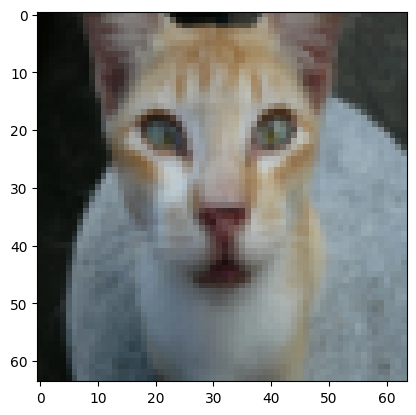

In [214]:
# Example of an image that was wrongly classified.

bad_indexes = []
for i in range(len(logistic_regression_model['Y_prediction_test'][0])):
    if logistic_regression_model['Y_prediction_test'][0][i] != test_set_y[0][i]:
        bad_indexes.append(i)

print("List of the bad indexes :",bad_indexes)

print("Let's look at the 4 first images that were wrongly classified :")
for index in bad_indexes[:4]:
    print("Index :",index, end=" ")
    plt.imshow(train_set_x_flatten[:, index].reshape((num_px, num_px, 3)))
    print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")


Run the cell below to compare the learning curve of our model with different choices of learning rates. Feel free to try different values and see what happens. 
    

Training a model with learning rate: 0.01
-------------------------------------------------------
Training a model with learning rate: 0.005
-------------------------------------------------------
Training a model with learning rate: 0.001
-------------------------------------------------------
Training a model with learning rate: 0.0001
-------------------------------------------------------


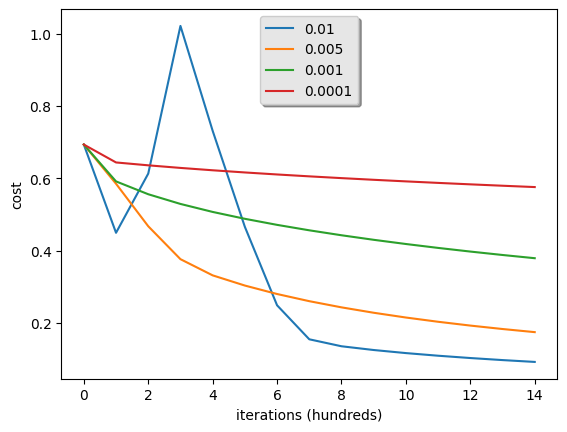

In [218]:
learning_rates = [0.01, 0.005, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x_flatten, train_set_y, test_set_x_flatten, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ("-------------------------------------------------------")

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Q2:**   
    
* What is the purpose of the learning rate in the gradient descent algorithm and how can it affect the performance of the model?
    
* Why it is important to use a well-tuned learning rate?
    
    
* Provide an interpretation of the results obtained above for different learning rates.

> **Q2.1** : The learning rate in the gradient descent algorithm is a hyperparameter that controls how much the weights of the model are updated in each iteration of the training process. Specifically, the learning rate determines the step size that the algorithm takes in the direction of the negative gradient of the loss function. A smaller learning rate means that the algorithm takes smaller steps, while a larger learning rate means that the algorithm takes larger steps.



> **Q2.2** : It is important to use a well-tuned learning rate because, in our case, the learning rate can greatly affect the performance of the model. If the learning rate is too small, the algorithm will take a long time to converge to an optimal solution, or it may get stuck in a local minimum. On the other hand, if the learning rate is too large, the algorithm may overshoot the optimal solution and fail to converge.

> **Q2.3** : We tested our model with 4 different learning rates : 0.01, 0.005, 0.001 and 0.0001.
> We notice that the lower the learning rate, the longer it takes to converge to an optimal solution. Moreover, greater the learning rate, the faster the algorithm converges to an optimal solution but the more likely it is to overshoot the optimal solution and may fail to converge. In our case, the 0.01 learning rate cost spikes up after 1000 iterations which is caused by the overshoot explained above (even tho it still manage to converge). 
>
> After the 1400 iterations, the cost is the lowest for the 0.01 learning rate.
<!-- > We might choose this learning rate because it is the fastest to converge to an optimal solution but because it caused an overshoot at the beginning  -->